In [1]:
import pandas as pd
from source import cls
import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
import pickle

In [2]:
user = pd.read_csv('dataset/user.csv')
book = pd.read_csv('dataset/book.csv')
print(len(user['ID'].unique()), len(book['Name']))

3822 30470


# Облака слов кластеров

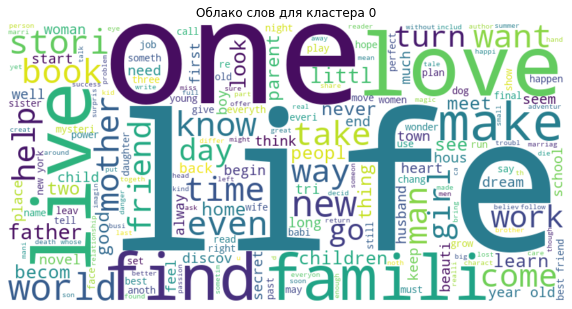

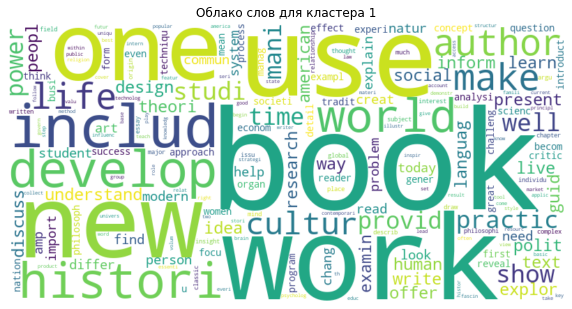

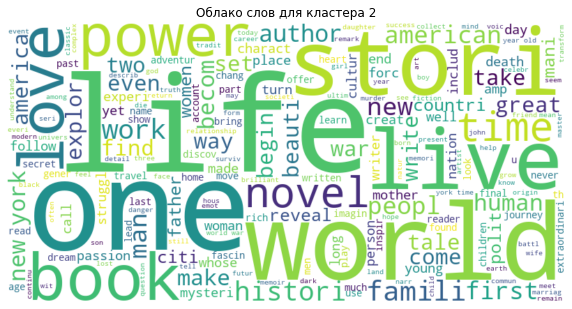

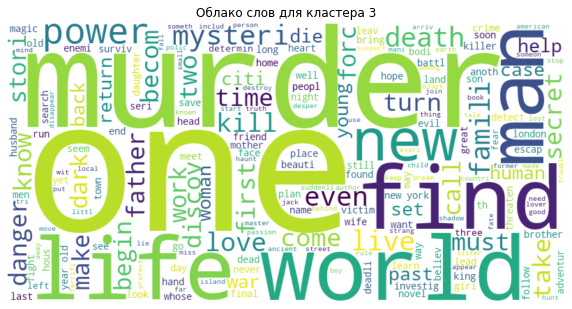

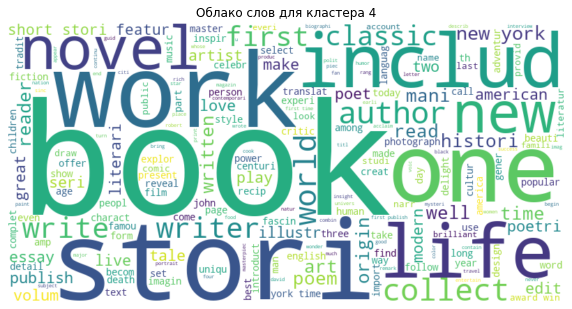

In [4]:
grouped_text = book.groupby('Cluster')['Stem_Description'].apply(lambda x: ' '.join(x)).reset_index()

# Создаем объект WordCloud для каждого кластера
for index, row in grouped_text.iterrows():
    cluster = row['Cluster']
    text = row['Stem_Description']
    
    # Генерируем облако слов для текста в текущем кластере
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Отображаем облако слов
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов для кластера {cluster}')
    plt.axis('off')
    plt.show()

## Частота слов в кластерах

In [5]:
# Создаем словарь для хранения наиболее часто встречающихся слов в каждом кластере
cluster_word_freq = {}

# Проходим по каждой строке DataFrame
for index, row in grouped_text.iterrows():
    cluster = row['Cluster']
    text = row['Stem_Description']
    
    # Токенизируем текст
    tokens = word_tokenize(text)
    
    # Создаем объект FreqDist для подсчета частоты слов
    fdist = FreqDist(tokens)
    
    # Получаем наиболее часто встречающиеся слова и их частоту
    top_words = fdist.most_common(20)  # Здесь выбираем 5 наиболее часто встречающихся слов
    
    # Сохраняем результаты в словарь cluster_word_freq
    cluster_word_freq[cluster] = top_words

# Выводим наиболее часто встречающиеся слова для каждого кластера
for cluster, top_words in cluster_word_freq.items():
    print(f"Кластер {cluster}:")
    for word, freq in top_words:
        print(f"Слово: {word}, Частота: {freq}")
    print()

Кластер 0:
Слово: one, Частота: 3045
Слово: life, Частота: 3040
Слово: love, Частота: 2591
Слово: new, Частота: 2301
Слово: find, Частота: 1956
Слово: time, Частота: 1794
Слово: live, Частота: 1757
Слово: famili, Частота: 1757
Слово: stori, Частота: 1741
Слово: make, Частота: 1735
Слово: get, Частота: 1696
Слово: book, Частота: 1632
Слово: friend, Частота: 1595
Слово: like, Частота: 1574
Слово: world, Частота: 1484
Слово: year, Частота: 1437
Слово: come, Частота: 1386
Слово: know, Частота: 1373
Слово: way, Частота: 1363
Слово: take, Частота: 1325

Кластер 1:
Слово: book, Частота: 4085
Слово: new, Частота: 2615
Слово: work, Частота: 2479
Слово: world, Частота: 1815
Слово: use, Частота: 1645
Слово: includ, Частота: 1521
Слово: cultur, Частота: 1507
Слово: one, Частота: 1447
Слово: histori, Частота: 1439
Слово: polit, Частота: 1330
Слово: provid, Частота: 1309
Слово: develop, Частота: 1234
Слово: make, Частота: 1213
Слово: time, Частота: 1201
Слово: author, Частота: 1174
Слово: way, Часто

In [6]:
user

,ID,Name,Rating,Rating_score,Rating_bin
0,1,The Restaurant at the End of the Universe (Hit...,it was amazing,5,1
1,73,The Restaurant at the End of the Universe (Hit...,really liked it,4,1
2,116,The Restaurant at the End of the Universe (Hit...,it was amazing,5,1
3,171,The Restaurant at the End of the Universe (Hit...,really liked it,4,1
4,338,The Restaurant at the End of the Universe (Hit...,liked it,3,0
...,...,...,...,...,...
173873,10978,Smile As They Bow,liked it,3,0
173874,10978,Speak Rwanda,really liked it,4,1
173875,10978,India After Gandhi: The History of the World's...,really liked it,4,1
173876,10988,Facing the Lion: Growing Up Maasai on the Afri...,liked it,3,0


# Рекомендации и классификаторы

In [3]:
df_train, df_test = train_test_split(user, test_size=0.2, random_state=12345)
# df_train = df_train.join(book.set_index('Name'), on='Name', how='inner').drop(['Rating', 'Description'], axis=1)
# df_test = df_test.join(book.set_index('Name'), on='Name', how='inner').drop(['Rating', 'Description'], axis=1)

`Краткое описание`: вычиляем, какие кластеры пользователь читал чаще всего. Если в `15%` или больше прочитанного, обучаем на нем классификатор и предсказываем оценки 0 или 1

In [33]:
id = 1
df = df_train[(df_train['ID'] == id) & (df_train['Rating_bin'] == 1)]

df = df.merge(book, on='Name')
df['Cluster'].value_counts().to_dict()

{2: 48, 3: 36, 0: 26, 4: 23, 1: 13}

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Функция для подбора рекомендаций и классификации 

with open('source/Word2Vec_array_29.03.2024.pk1', 'rb') as f:
    documents_dict = pickle.load(f)

def reco_classifier(id: int, threshold: float=15.0):
    """Алгоритм: считаем в каких кластерах было больше всего понравившихся книг, обучаем классификаторы к тех кластерах, где больше 15% понравившихся от общего числа понравившихся"""
    # сначала расчет понравившихся кластеров
    like_df = df_train[(df_train['ID'] == id) & (df_train['Rating_bin'] == 1)]
    like_df = like_df.merge(book, on='Name')

    cluster_dict = like_df['Cluster'].value_counts().to_dict()

    cluster = cluster_dict.keys()
    percent = np.round(np.array(list(cluster_dict.values())) / sum(cluster_dict.values()) * 100)

    percent_cluster = dict(zip(percent, cluster))

    df = df_train[(df_train['ID'] == id)]   # Подготовка датафрейма с текущим id
    df = df.merge(book, on='Name')

    df_exam = df_test[(df_test['ID'] == id)]
    df_exam = df_exam.merge(book, on='Name')

    accuracy = []

    for key in list(percent_cluster.keys()):
        if key >= threshold:
            temp_df = df[df['Cluster'] == percent_cluster[key]]

            X_train = [documents_dict.get(name) for name in list(temp_df['Name'])]
            y_train = temp_df['Rating_bin']


            dt_classifier = DecisionTreeClassifier()

            # Определение сетки параметров для перебора
            param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

            # Создание объекта GridSearchCV для автоматического подбора параметров
            grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=2)

            grid_search.fit(X_train, y_train)

            # print("Наилучшие параметры:", grid_search.best_params_)

            temp_df_exam = df_exam[df_exam['Cluster'] == percent_cluster[key]]

            X_test = [documents_dict.get(key) for key in list(temp_df_exam['Name'])]
            y_test = temp_df_exam['Rating_bin']
            accuracy.append(grid_search.score(X_test, y_test))

    return accuracy

In [78]:
user.head(100)

accuracy = []

for i in user.head(10).ID:
    print(i)
    accuracy.append(reco_classifier(i))

1


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


73
116
171


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


338
524


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


897
1327


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


1792
1910


In [79]:
accuracy

[[0.5416666666666666, 0.6666666666666666, 0.75, 1.0],
 [0.47058823529411764, 0.4166666666666667, 0.2857142857142857],
 [1.0, 1.0],
 [1.0, 1.0, 1.0],
 [0.5, 0.4230769230769231],
 [0.7777777777777778, 0.8, 0.4, 0.25],
 [0.4444444444444444, 0.5714285714285714, 0.6666666666666666],
 [0.25, 0.6111111111111112, 0.8333333333333334],
 [0.0],
 [0.16666666666666666, 0.625, 0.7142857142857143, 0.4]]

In [61]:
user[user.ID==73]

,ID,Name,Rating,Rating_score,Rating_bin
1,73,The Restaurant at the End of the Universe (Hit...,really liked it,4,1
319,73,"The Hunger Games (The Hunger Games, #1)",really liked it,4,1
769,73,The Authoritative Calvin and Hobbes: A Calvin ...,it was amazing,5,1
2805,73,King Leopold's Ghost,really liked it,4,1
5039,73,The Remains of the Day,it was ok,2,0
...,...,...,...,...,...
72032,73,The Man Who Sold the Moon,liked it,3,0
72036,73,The Most Dangerous Game,really liked it,4,1
72039,73,The Discomfort Zone: A Personal History,really liked it,4,1
72051,73,Beyond the Hundredth Meridian: John Wesley Pow...,really liked it,4,1


In [42]:
cluster_dict = df['Cluster'].value_counts().to_dict()

cluster = cluster_dict.keys()
percent = np.round(np.array(list(cluster_dict.values())) / sum(cluster_dict.values()) * 100)

new_dict = dict(zip(percent, cluster))
new_dict

{33.0: 2, 25.0: 3, 18.0: 0, 16.0: 4, 9.0: 1}

In [48]:
type(list(new_dict.keys())[0])

numpy.float64

In [29]:
round(0.14753424657534246 * 100)

15

In [20]:
with open('source/Word2Vec_array_29.03.2024.pk1', 'rb') as f:
    documents_dict = pickle.load(f)

In [21]:
df = df_train[(df_train['ID'] == id)]
df = df.merge(book, on='Name')
df = df[df['Cluster'] == 3]
df

,ID,Name,Rating,Rating_score,Rating_bin,Description,Stem_Description,Cluster
3,1,Dark Apprentice (Star Wars: The Jedi Academy T...,liked it,3,0,As the New Republic takes devastating losses i...,new republ take devast loss ongo war scatter ...,3
6,1,"The Lost Symbol (Robert Langdon, #3)",liked it,3,0,WHAT WAS LOST WILL BE FOUND…Washington DC: Har...,lost found…washington dc harvard symbologist ...,3
10,1,"A Dance with Dragons (A Song of Ice and Fire, #5)",it was amazing,5,1,"In the aftermath of a colossal battle, the fut...",aftermath coloss battl futur seven kingdom ha...,3
13,1,Cyrus the Unsinkable Sea Serpent,it was amazing,5,1,A shark accuses Cyrus of cowardice because he ...,shark accus cyru cowardic wo sink ship kindli...,3
14,1,The Da Vinci Code,really liked it,4,1,Alternative Cover Edition ISBN 0385513224 (ISB...,altern cover edit isbn 0385513224 isbn13 9780...,3
25,1,"Speaker for the Dead (Ender's Saga, #2)",really liked it,4,1,"In the aftermath of his terrible war, Ender Wi...",aftermath terribl war ender wiggin disappear ...,3
27,1,"Diamonds Are Forever (James Bond, #4)",really liked it,4,1,James Bond is on one of his toughest assignmen...,jame bond one toughest assign infiltr diamond...,3
30,1,The Fellowship of the Ring (The Lord of the Ri...,it was amazing,5,1,"Continuing the story begun in The Hobbit, this...",continu stori begun hobbit first part tolkien...,3
31,1,Harry Potter and the Chamber of Secrets (Harry...,really liked it,4,1,When the Chamber of Secrets is opened again at...,chamber secret open hogwart school witchcraft...,3
37,1,Heir to the Empire (Star Wars: The Thrawn Tril...,liked it,3,0,It's five years after <i>Return of the Jedi:</...,five year return jedi rebel allianc destroy d...,3


In [22]:
documents_dict

# Подготовка данных 
X = [documents_dict.get(key) for key in list(df['Name'])]
y = df['Rating_bin']

In [23]:
df = df_test[(df_test['ID'] == id)]
df = df.merge(book, on='Name')
df = df[df['Cluster'] == 3]

X_test = [documents_dict.get(key) for key in list(df['Name'])]
y_test = df['Rating_bin']

In [24]:
svm_classifier = svm.SVC()

# Определение сетки параметров для перебора
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}

# Создание объекта GridSearchCV для автоматического подбора параметров
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)

# Обучение классификатора с автоматическим подбором параметров
grid_search.fit(X, y)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search.best_params_)

# Оценка производительности на тестовом наборе данных
accuracy = grid_search.score(X_test, y_test)
print("Точность на тестовом наборе данных:", accuracy)

Наилучшие параметры: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Точность на тестовом наборе данных: 0.8


In [26]:
grid_search.predict(X_test)

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int64)

In [39]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split

# Загрузка набора данных
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание классификатора SVM
svm_classifier = svm.SVC()

# Определение сетки параметров для перебора
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}

# Создание объекта GridSearchCV для автоматического подбора параметров
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)

# Обучение классификатора с автоматическим подбором параметров
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search.best_params_)

# Оценка производительности на тестовом наборе данных
accuracy = grid_search.score(X_test, y_test)
print("Точность на тестовом наборе данных:", accuracy)


Наилучшие параметры: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Точность на тестовом наборе данных: 1.0


In [11]:
3 / (10+8+3+4)

0.12

In [28]:
# Имеем два списка
ключи = ['a', 'b', 'c']
значения = [1, 2, 3]

# Создаем словарь из двух списков
словарь = dict(zip(ключи, значения))

print(словарь)  # Вывод: {'a': 1, 'b': 2, 'c': 3}


{'a': 1, 'b': 2, 'c': 3}
